In [1]:
#!pip install statsmodels

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import seaborn


import statsmodels
from statsmodels.tsa.stattools import coint
np.random.seed(107)

import matplotlib.pyplot as plt

In [4]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2000/10/30'
endDateStr = '2020/10/30'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['AXP', 'GS', 'JPM', 'TRV', 'V']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: AXP
Processing data for stock: GS
Processing data for stock: JPM
Processing data for stock: TRV
Processing data for stock: V
20% done...
40% done...
60% done...
80% done...


In [5]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [6]:
print(data['V'][:1855])

2000-10-30          NaN
2000-10-31          NaN
2000-11-01          NaN
2000-11-02          NaN
2000-11-03          NaN
                ...    
2008-03-13          NaN
2008-03-14          NaN
2008-03-17          NaN
2008-03-18          NaN
2008-03-19    12.901475
Name: V, Length: 1855, dtype: float64


In [7]:
data['V'].fillna(12.901475, inplace = True)

In [8]:
data.head()

,AXP,GS,JPM,TRV,V
2000-10-30,38.565105,76.302032,24.047834,30.907969,12.901475
2000-10-31,39.596268,78.921181,25.009748,30.720642,12.901475
2000-11-01,38.523861,76.450249,25.112803,30.495869,12.901475
2000-11-02,38.028908,78.476410,25.009748,29.971371,12.901475
2000-11-03,39.348793,79.415367,24.425734,28.847435,12.901475


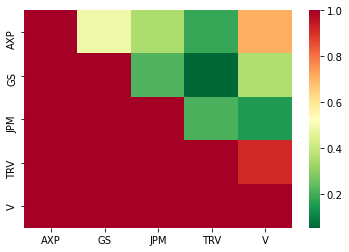

[]


In [9]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn

m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                )
plt.show()
print(pairs)

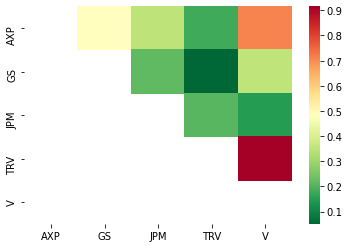

[]


In [10]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

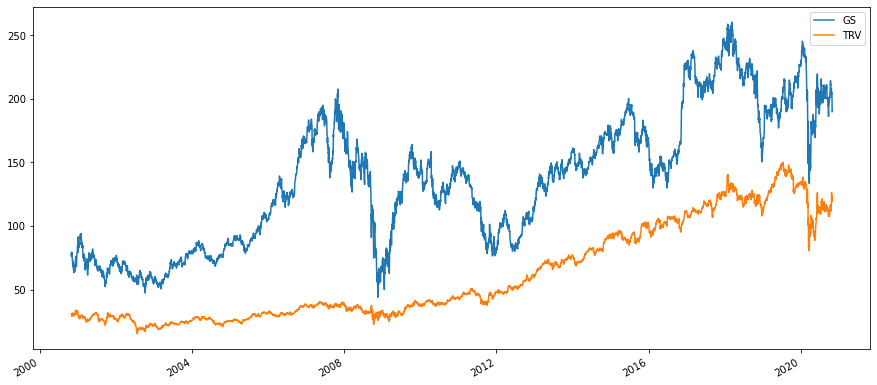

In [11]:
S1 = data['GS']
S2 = data['TRV']
pd.concat([S1, S2], axis=1).plot(figsize=(15,7))
plt.show()

0.051454815466944526


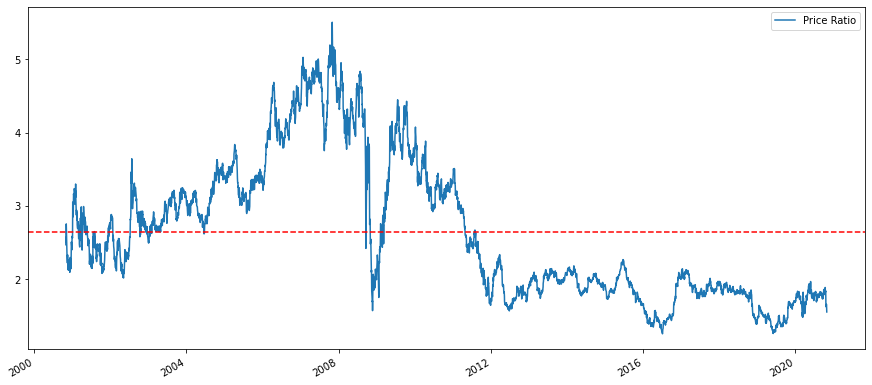

In [12]:

score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean(), color='red', linestyle='--')
plt.legend(['Price Ratio'])
plt.show()

In [13]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

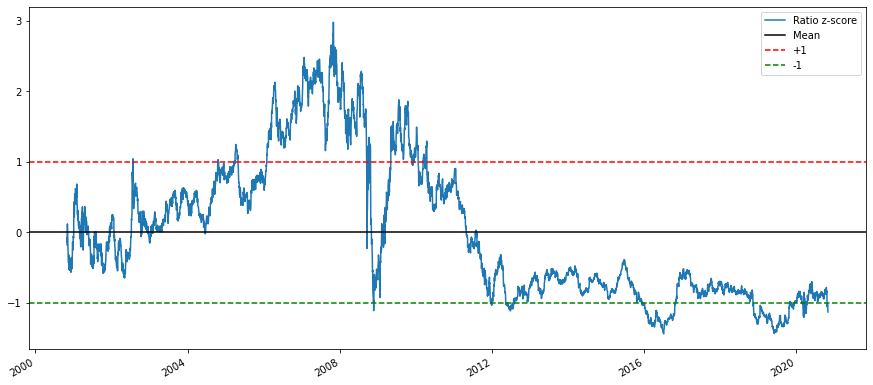

In [14]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [15]:
data = pd.DataFrame()
data['GS'] = S1
data['TRV'] = S2

In [16]:
#label = 1, buy GS sell TRV
#label = 0, buy TRV sell GS
#label = 0.5, clear out positions

In [17]:
data

,GS,TRV
2000-10-30,76.302032,30.907969
2000-10-31,78.921181,30.720642
2000-11-01,76.450249,30.495869
2000-11-02,78.476410,29.971371
2000-11-03,79.415367,28.847435
...,...,...
2020-10-23,205.039993,125.970001
2020-10-26,201.139999,121.540001
2020-10-27,195.679993,119.089996
2020-10-28,189.770004,121.500000


In [18]:
data.reset_index(inplace = True)

In [19]:
labels = []
for i in range(data.shape[0]-1):
    GS_ret = (data.loc[i+1,'GS'] - data.loc[i,'GS'])/data.loc[i,'GS']
    TRV_ret = (data.loc[i+1, 'TRV'] - data.loc[i, 'TRV'])/data.loc[i, 'TRV']
    if GS_ret - TRV_ret > 0:
        labels.append(1)
    elif GS_ret - TRV_ret <0:
        labels.append(0)
    

In [20]:
data = data.iloc[:len(data)-1]

In [21]:
data['labels'] = labels

In [22]:
data.head()

,index,GS,TRV,labels
0,2000-10-30,76.302032,30.907969,1
1,2000-10-31,78.921181,30.720642,0
2,2000-11-01,76.450249,30.495869,1
3,2000-11-02,78.476410,29.971371,1
4,2000-11-03,79.415367,28.847435,0


In [23]:
ratios = data['GS']/data['TRV']

In [24]:
data['ratios'] = ratios

In [25]:
ratios_mavg3 = data['ratios'].rolling(window=3,
                               center=False).mean()

ratios_mavg150 = data['ratios'].rolling(window=150,
                               center=False).mean()

std_150 = data['ratios'].rolling(window=150,
                        center=False).std()

zscore_150_3 = (ratios_mavg3 - ratios_mavg150)/std_150

In [26]:
ratios_mavg60 = data['ratios'].rolling(window=60,
                               center=False).mean()

ratios_mavg150 = data['ratios'].rolling(window=150,
                               center=False).mean()

std_150 = data['ratios'].rolling(window=150,
                        center=False).std()

zscore_150_60 = (ratios_mavg60 - ratios_mavg150)/std_150

In [27]:
data['3_150_zscore'] = zscore_150_3
data['60_150_zscore'] = zscore_150_60

In [28]:
data.head(150)

,index,GS,TRV,labels,ratios,3_150_zscore,60_150_zscore
0,2000-10-30,76.302032,30.907969,1,2.468685,NaN,NaN
1,2000-10-31,78.921181,30.720642,0,2.568995,NaN,NaN
2,2000-11-01,76.450249,30.495869,1,2.506905,NaN,NaN
3,2000-11-02,78.476410,29.971371,1,2.618379,NaN,NaN
4,2000-11-03,79.415367,28.847435,0,2.752944,NaN,NaN
...,...,...,...,...,...,...,...
145,2001-05-30,75.100304,30.507687,0,2.461685,NaN,NaN
146,2001-05-31,75.369736,30.689642,1,2.455869,NaN,NaN
147,2001-06-01,76.637794,30.071003,0,2.548561,NaN,NaN
148,2001-06-04,76.487221,30.174093,0,2.534864,NaN,NaN


In [29]:
data['GS_returns'] = (data['GS'].shift(1) - data['GS'])/data['GS']

In [30]:
data['TRV_returns'] = (data['TRV'].shift(1) - data['TRV'])/data['TRV']

In [31]:
data

,index,GS,TRV,labels,ratios,3_150_zscore,60_150_zscore,GS_returns,TRV_returns
0,2000-10-30,76.302032,30.907969,1,2.468685,NaN,NaN,NaN,NaN
1,2000-10-31,78.921181,30.720642,0,2.568995,NaN,NaN,-0.033187,0.006098
2,2000-11-01,76.450249,30.495869,1,2.506905,NaN,NaN,0.032321,0.007371
3,2000-11-02,78.476410,29.971371,1,2.618379,NaN,NaN,-0.025819,0.017500
4,2000-11-03,79.415367,28.847435,0,2.752944,NaN,NaN,-0.011823,0.038961
...,...,...,...,...,...,...,...,...,...
5026,2020-10-22,205.399994,126.139999,0,1.628349,-1.311084,0.121472,-0.012123,-0.009038
5027,2020-10-23,205.039993,125.970001,1,1.627689,-1.912573,0.095405,0.001756,0.001350
5028,2020-10-26,201.139999,121.540001,0,1.654928,-1.782900,0.077961,0.019389,0.036449
5029,2020-10-27,195.679993,119.089996,0,1.643127,-1.707584,0.059575,0.027903,0.020573


In [32]:
data['GS_mean'] = data['GS_returns'].rolling(window=5, center=False).mean()
data['TRV_mean'] = data['TRV_returns'].rolling(window=5, center=False).mean()

In [33]:
data = data.iloc[149:]

In [34]:
data.reset_index(inplace = True, drop = True)

In [35]:
data.head()

,index,GS,TRV,labels,ratios,3_150_zscore,60_150_zscore,GS_returns,TRV_returns,GS_mean,TRV_mean
0,2001-06-05,77.152916,30.768496,0,2.507530,-0.414308,0.129065,-0.008628,-0.019319,-0.000882,-0.003447
1,2001-06-06,75.718513,30.477373,1,2.484417,-0.487874,0.131378,0.018944,0.009552,-0.001567,0.000292
2,2001-06-07,76.796303,30.265095,0,2.537455,-0.484084,0.129243,-0.014034,0.007014,-0.003659,0.002881
3,2001-06-08,75.575806,30.186247,0,2.503650,-0.488412,0.127608,0.016149,0.002612,0.002880,-0.000711
4,2001-06-11,72.920822,30.277206,0,2.408440,-0.568926,0.118772,0.036409,-0.003004,0.009768,-0.000629


In [36]:
data.shape

(4882, 11)

In [37]:
train = data[:2929]

In [38]:
val = data[2929:3905]

In [39]:
test = data[3905:]

In [40]:
train.index = train['index']
train.drop('index', axis =1, inplace = True)

In [41]:
val.index = val['index']
val.drop('index', axis =1, inplace = True)

In [42]:
test.index = test['index']
test.drop('index', axis =1, inplace = True)

In [43]:
train.head()

,GS,TRV,labels,ratios,3_150_zscore,60_150_zscore,GS_returns,TRV_returns,GS_mean,TRV_mean
index,,,,,,,,,,
2001-06-05,77.152916,30.768496,0,2.507530,-0.414308,0.129065,-0.008628,-0.019319,-0.000882,-0.003447
2001-06-06,75.718513,30.477373,1,2.484417,-0.487874,0.131378,0.018944,0.009552,-0.001567,0.000292
2001-06-07,76.796303,30.265095,0,2.537455,-0.484084,0.129243,-0.014034,0.007014,-0.003659,0.002881
2001-06-08,75.575806,30.186247,0,2.503650,-0.488412,0.127608,0.016149,0.002612,0.002880,-0.000711
2001-06-11,72.920822,30.277206,0,2.408440,-0.568926,0.118772,0.036409,-0.003004,0.009768,-0.000629


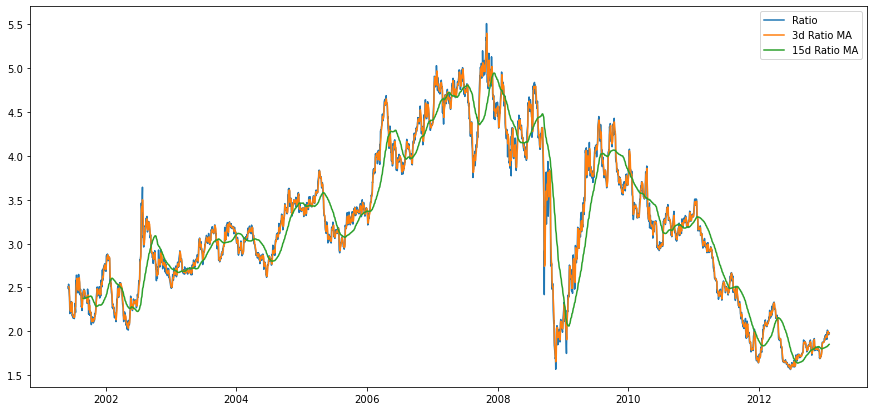

In [44]:
plt.figure(figsize=(15,7))
plt.plot(train.index, train.ratios)
plt.plot(train.index, train.ratios.rolling(window=3,
                               center=False).mean())
plt.plot(train.index, train.ratios.rolling(window=60,
                               center=False).mean())
plt.legend(['Ratio','3d Ratio MA', '15d Ratio MA'])
plt.show()

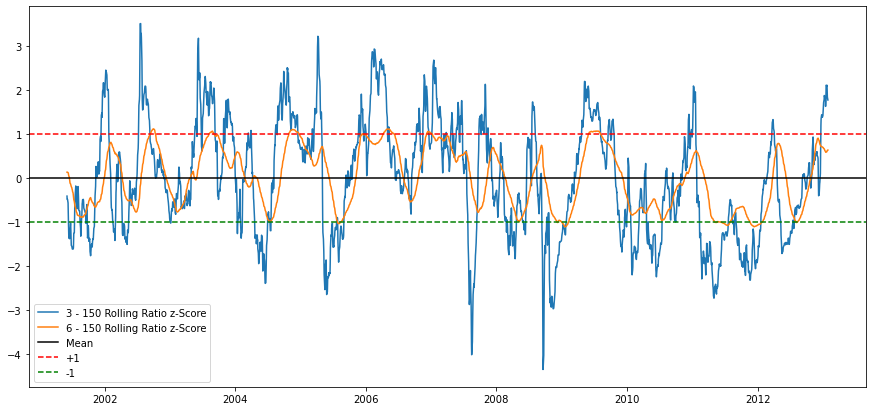

In [45]:
plt.figure(figsize=(15,7))
plt.plot(train.index, train['3_150_zscore'])
plt.plot(train.index, train['60_150_zscore'])

plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['3 - 150 Rolling Ratio z-Score','6 - 150 Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

In [73]:
train.head()

,GS,TRV,labels,ratios,3_150_zscore,60_150_zscore,GS_returns,TRV_returns,GS_mean,TRV_mean
index,,,,,,,,,,
2001-06-05,77.152916,30.768496,0,2.507530,-0.414308,0.129065,-0.008628,-0.019319,-0.000882,-0.003447
2001-06-06,75.718513,30.477373,1,2.484417,-0.487874,0.131378,0.018944,0.009552,-0.001567,0.000292
2001-06-07,76.796303,30.265095,0,2.537455,-0.484084,0.129243,-0.014034,0.007014,-0.003659,0.002881
2001-06-08,75.575806,30.186247,0,2.503650,-0.488412,0.127608,0.016149,0.002612,0.002880,-0.000711
2001-06-11,72.920822,30.277206,0,2.408440,-0.568926,0.118772,0.036409,-0.003004,0.009768,-0.000629


In [119]:
from sklearn.tree import DecisionTreeClassifier

In [120]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [134]:
Y = train['labels']

In [135]:
X = train[['ratios', '3_150_zscore', '60_150_zscore','GS_returns', 'TRV_returns', 'GS_mean', 'TRV_mean']]

In [136]:
clf = DecisionTreeClassifier(random_state = 1, min_samples_split = 12, max_depth = 10)#, min_samples_split = 10)
clf.fit(X, Y)
print(confusion_matrix(Y, clf.predict(X)))
print(accuracy_score(Y, clf.predict(X)))

[[1322  141]
 [1164  302]]
0.5544554455445545


In [137]:
Y = val['labels']
X = val[['ratios', '3_150_zscore', '60_150_zscore','GS_returns', 'TRV_returns', 'GS_mean', 'TRV_mean']]

In [138]:
print(confusion_matrix(Y, clf.predict(X)))
print(accuracy_score(Y, clf.predict(X)))

[[358 142]
 [330 146]]
0.5163934426229508


In [139]:
train

,GS,TRV,labels,ratios,3_150_zscore,60_150_zscore,GS_returns,TRV_returns,GS_mean,TRV_mean
index,,,,,,,,,,
2001-06-05,77.152916,30.768496,0,2.507530,-0.414308,0.129065,-0.008628,-0.019319,-0.000882,-0.003447
2001-06-06,75.718513,30.477373,1,2.484417,-0.487874,0.131378,0.018944,0.009552,-0.001567,0.000292
2001-06-07,76.796303,30.265095,0,2.537455,-0.484084,0.129243,-0.014034,0.007014,-0.003659,0.002881
2001-06-08,75.575806,30.186247,0,2.503650,-0.488412,0.127608,0.016149,0.002612,0.002880,-0.000711
2001-06-11,72.920822,30.277206,0,2.408440,-0.568926,0.118772,0.036409,-0.003004,0.009768,-0.000629
...,...,...,...,...,...,...,...,...,...,...
2013-01-22,129.490784,64.988861,1,1.992507,2.081707,0.591379,-0.010278,-0.021039,-0.013705,-0.007793
2013-01-23,129.144745,64.730438,0,1.995116,2.100980,0.605297,0.002679,0.003992,-0.013966,-0.005380
2013-01-24,128.612427,65.105606,0,1.975443,1.953251,0.616630,0.004139,-0.005762,-0.005341,-0.006559


In [140]:
#label = 1, buy GS sell TRV
#label = 0, buy TRV sell GS
#label = 0.5, clear out positions

In [141]:
def trade(S1, S2, predictions, return_money_seq = False):
    money = 0
    countS1 = 0
    countS2 = 0
    ratio = S1/S2
    mon_seq = [0]
    for i in range(len(predictions)):
        if predictions[i] > 0.7:
            money -= S1[i] + S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            pass
        elif predictions[i] < 0.3:
            money += S1[i] + S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            pass
        elif predictions[i]<0.55 and predictions[i]>0.45:
            money += countS1*S1[i] + S2[i]*countS2
            pass
        mon_seq.append(money)
        #print(money, countS1, countS2)
        pass
    if return_money_seq == True:
        return mon_seq
    return money


In [142]:
X_train = train[['ratios', '3_150_zscore', '60_150_zscore','GS_returns', 'TRV_returns', 'GS_mean', 'TRV_mean']]
preds = clf.predict_proba(X_train)

In [143]:
preds = [j[1] for j in preds]

In [144]:
trade(train['GS'], train['TRV'], preds)

1412438.6662649133

In [145]:
X_train = val[['ratios', '3_150_zscore', '60_150_zscore','GS_returns', 'TRV_returns', 'GS_mean', 'TRV_mean']]
preds = clf.predict_proba(X_train)
preds = [j[1] for j in preds]
trade(val['GS'], val['TRV'], preds)

174781.88875239933

In [146]:
X_train = test[['ratios', '3_150_zscore', '60_150_zscore','GS_returns', 'TRV_returns', 'GS_mean', 'TRV_mean']]
preds = clf.predict_proba(X_train)
preds = [j[1] for j in preds]
trade(test['GS'], test['TRV'], preds)

959459.4648990772

In [147]:
preds = np.array(preds)

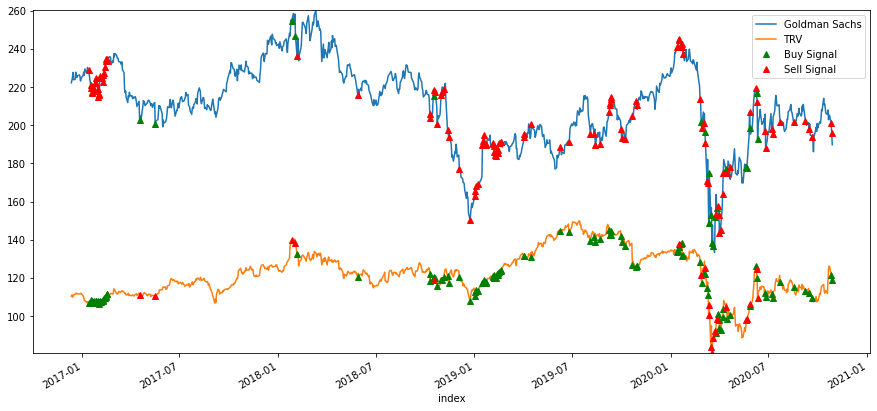

In [148]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))
S1 = test['GS']
S2 = test['TRV']
S1.plot()
S2.plot()
buy = 0*S1.copy()
sell = 0*S1.copy()
close = 0*S1.copy()
buy[preds>0.7] = S1[preds>0.7]
sell[preds>0.7] = S2[preds>0.7]

sell[preds<0.3] = S1[preds<0.3]
buy[preds<0.3] = S2[preds<0.3]


buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.legend(['Goldman Sachs','TRV', 'Buy Signal', 'Sell Signal'])
plt.show()

In [149]:
out = trade(test['GS'], test['TRV'], preds, return_money_seq=True)

Text(0.5, 1.0, 'Returns')

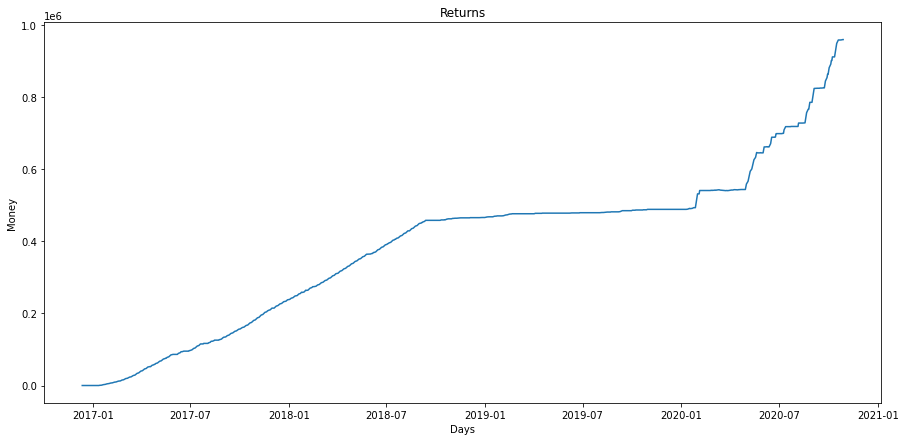

In [150]:
plt.figure(figsize=(15,7))
plt.plot(test.index,out[1:])
plt.xlabel('Days')
plt.ylabel('Money')
plt.title('Returns')